<img src="../../img/emergent_filters.png" alt="Emergent Filters" style="width: 100%; border-radius: 20px;"/>

## Objective
Our first approach to detecting unusual sightings is adapted directly from eBird, an established citizen science project that allows the general public to contribute to a global database of bird observations. Part of their process is what they call Emergent Filters, which only factor in the location and date of the sighting.

An Emergent Filter, as described by eBird, is a data-driven filter that emerges from the analysis of historical data. Instead of using pre-defined filters set by experts, the Emergent Filter is generated based on patterns and frequencies observed in the historical data itself. [1] 

In the specific case of the eBird project, the Emergent Filter is based on the frequency of reporting a species. The frequency is calculated as the number of checklists (i.e. sightings) that reported a particular species divided by the total number of checklists submitted for a specific region. Checklists of species whose occurrence frequency surpasses a pre-defined threshold are included in the eBird database, while observations falling below the threshold are flagged as unusual. The Emergent Data filter is constantly updated as new data is reported, making it a dynamic and adaptive mechanism for identifying patterns and outliers in bird observations [1].

We decided to adopt this approach due to its established usage at eBird. Additionally, we intend to use this approach as a benchmark for our Outlier Detection approach, which also incorporates more sophisticated features such as land use, altitude, etc. (see *02_Outlier_Detection.ipynb*).

## Scope
In this notebook, we implement this concept and calculate Emergent Filters for the 27 species chosen by ornitho.de and ornitho.ch. Additionally, we showcase some selected species' filters over the course of the year to assess their potential effectiveness and demonstrate how to utilize Emergent Filters for flagging unusual sightings.

## Limitation
The evaluation and optimization of this approach is not within the scope of this notebook since at the time this notebook was employed, no evaluation data was available. It will be conducted in the future in the chapter *03_evaluation* as part of the *Hauptprojekt*.

## Output data
You can download the Emergent Filter lookup table using 50x50km grids for prediction of 2023 data [here](https://drive.google.com/drive/folders/10jRb7Gxx2Q9mgGDYUaIFq8QAAzW3lQD4).

In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Itim";
        font color: #d8c0b5;
    }
</style>

In [2]:
import pickle
import pandas as pd
import plotly.express as px

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following file is required:
- Master dataset reduced to 27 species and enriched with EEA grids: *[selected_species_with_50km_grids.csv](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e)*

If you wish to store the resulting Emergent Filter lookup table for later predictions (in pkl format), please specify a target path where it should be stored.

In [3]:
data = '../../../01_Data/datasets/selected_species_with_50km_grids.csv'  # please provide path to selected_bird_species_with_grids_50km.csv

target_path = 'emergent_filters_selected_species_grids_50km.pkl'  # please provide pkl-path where emergent filters should be stored, e.g. 'emergent_filters.pkl'

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 1️⃣ Load data </p>

In this notebook, we compute the Emergent Filters for the year 2023 for the 27 species of interest. This computation is based on the data from the year 2022. To achieve this, we narrow down the available data to sightings in the year 2022. 

In [4]:
bird_sightings = pd.read_csv(data, index_col=0, low_memory=False).reset_index(drop=True)
bird_sightings = bird_sightings[bird_sightings.date.str.contains('2022')]
bird_sightings.head()

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id
3760,63647819,531,Rohrammer,2022-01-01,11:24,48.262305,7.831647,precise,0,3.0,NaN,60767,de,50kmE4150N2750
3761,63681607,469,Bergpieper,2022-01-01,NaN,51.338265,6.360221,place,0,2.0,NaN,126568,de,50kmE4050N3100
3762,63681018,463,Wiesenpieper,2022-01-01,NaN,50.734383,6.756544,place,0,4.0,NaN,56346,de,50kmE4050N3050
3763,63654383,463,Wiesenpieper,2022-01-01,NaN,48.532775,8.215624,place,0,0.0,NaN,45047,de,50kmE4150N2800
3764,63667735,8,Haubentaucher,2022-01-01,NaN,50.407654,7.507958,place,0,4.0,NaN,37530,de,50kmE4100N3000


# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣ Creating Emergent Filters </p>
Emergent Filters calculate the relative proportions of bird sightings for each species in the past year. From this, they derive the probability of a bird sighting for each species, grid, and date in the following year. This process results in probability curves throughout the year for sighting a particular bird species within a specific grid.

Similar to the approach used in eBird, each sighting is assigned a 'day of year' value, ranging from 1 to 365 [1]. Additionally, since the Emergent Filters only utilize the species name, the location and the day of the sighting, we first drop all unused columns. 

In [5]:

bird_sightings['day_of_year'] = pd.to_datetime(bird_sightings.date).dt.dayofyear
bird_sightings.drop(columns=['id_sighting', 'id_species', 'timing', 'date', 'coord_lat', 'coord_lon', 'precision', 'altitude', 'total_count', 'atlas_code', 'id_observer', 'country'], inplace=True)

In [6]:
bird_sightings

,name_species,eea_grid_id,day_of_year
3760,Rohrammer,50kmE4150N2750,1
3761,Bergpieper,50kmE4050N3100,1
3762,Wiesenpieper,50kmE4050N3050,1
3763,Wiesenpieper,50kmE4150N2800,1
3764,Haubentaucher,50kmE4100N3000,1
...,...,...,...
2660035,Steinschmätzer,50kmE4200N2600,213
2660036,Steinschmätzer,50kmE4200N2700,288
2660037,Schwarzkehlchen,50kmE4200N2700,288
2660038,Bergpieper,50kmE4200N2600,213


Next, eBird computes a metric that reflects the frequency of species reporting. This metric is obtained by dividing the number of checklists reporting a specific species by the total number of checklists submitted for a particular region. The outcome provides an indication of the 'probability' of encountering a particular bird species within that specific region. Since each observation includes information about the bird's location and time of detection, it becomes feasible to calculate the occurrence frequencies of bird species at various spatial scales and for any given date [1].

We implement this concept through a multi-step process.

Initially, we generate a dataframe encompassing all potential combinations of bird species, EEA grids, and dates. This step is aimed to calculate the likelihood of a sighting for all possible combinations.

In [7]:
# fill an empty df so that we have all possible day/grid combinations
grid_list = bird_sightings.eea_grid_id.unique()
day_list = range(1, 366)
species_list = bird_sightings.name_species.unique()
all_combinations = pd.MultiIndex.from_product([species_list, grid_list, day_list], names=['name_species', 'eea_grid_id', 'day_of_year'])
all_combinations = pd.DataFrame(index=all_combinations).reset_index()
all_combinations

,name_species,eea_grid_id,day_of_year
0,Rohrammer,50kmE4150N2750,1
1,Rohrammer,50kmE4150N2750,2
2,Rohrammer,50kmE4150N2750,3
3,Rohrammer,50kmE4150N2750,4
4,Rohrammer,50kmE4150N2750,5
...,...,...,...
2207515,Gänsegeier,50kmE4150N2500,361
2207516,Gänsegeier,50kmE4150N2500,362
2207517,Gänsegeier,50kmE4150N2500,363
2207518,Gänsegeier,50kmE4150N2500,364


Subsequently, for each combination, the total number of all submitted sightings on that specific day and grid is determined. 

E.g., on Jan 1st, in grid 50kmE4150N2750 (area arond Freiburg im Breisgau), 32 sightings of different species were submitted.

In [8]:
# number of all sightings per grid per day
by_days = bird_sightings.groupby(['day_of_year', 'eea_grid_id']).count().reset_index()
by_days.rename(columns={'name_species':'total_sightings'}, inplace=True)
by_days = all_combinations.merge(by_days, on=['eea_grid_id', 'day_of_year'], how='left')
by_days['total_sightings'] = by_days['total_sightings'].fillna(0).astype(int)
by_days

,name_species,eea_grid_id,day_of_year,total_sightings
0,Rohrammer,50kmE4150N2750,1,32
1,Rohrammer,50kmE4150N2750,2,14
2,Rohrammer,50kmE4150N2750,3,12
3,Rohrammer,50kmE4150N2750,4,1
4,Rohrammer,50kmE4150N2750,5,16
...,...,...,...,...
2207515,Gänsegeier,50kmE4150N2500,361,0
2207516,Gänsegeier,50kmE4150N2500,362,0
2207517,Gänsegeier,50kmE4150N2500,363,0
2207518,Gänsegeier,50kmE4150N2500,364,0


Then, the count of all submitted sightings of the corresponding bird species on that day and grid is added.

E.g., on Jan 1st, 7/32 sightings in 50kmE4150N2750 reported a bittern (*Rohrammer*).

In [9]:
# number of sightings for specific species per day per grid
by_days_and_species = bird_sightings.groupby(['name_species', 'day_of_year', 'eea_grid_id']).size().reset_index()
by_days_and_species.rename(columns={0:'n_sightings'}, inplace=True)
by_days_and_species

total_df = by_days.merge(by_days_and_species, on=['name_species', 'eea_grid_id', 'day_of_year'], how='left')
total_df['n_sightings'] = total_df['n_sightings'].fillna(0).astype(int)
total_df

,name_species,eea_grid_id,day_of_year,total_sightings,n_sightings
0,Rohrammer,50kmE4150N2750,1,32,7
1,Rohrammer,50kmE4150N2750,2,14,1
2,Rohrammer,50kmE4150N2750,3,12,3
3,Rohrammer,50kmE4150N2750,4,1,0
4,Rohrammer,50kmE4150N2750,5,16,2
...,...,...,...,...,...
2207515,Gänsegeier,50kmE4150N2500,361,0,0
2207516,Gänsegeier,50kmE4150N2500,362,0,0
2207517,Gänsegeier,50kmE4150N2500,363,0,0
2207518,Gänsegeier,50kmE4150N2500,364,0,0


Finally, we calculate the likelihood or frequency of bird sightings, following the methodology employed by eBird. This is expressed as:
$$frequency = \frac{n\_sightings}{total\_sightings}$$

In [10]:
total_df['frequency'] = total_df.n_sightings / total_df.total_sightings
total_df['frequency'] = total_df['frequency'].fillna(0)
total_df

,name_species,eea_grid_id,day_of_year,total_sightings,n_sightings,frequency
0,Rohrammer,50kmE4150N2750,1,32,7,0.218750
1,Rohrammer,50kmE4150N2750,2,14,1,0.071429
2,Rohrammer,50kmE4150N2750,3,12,3,0.250000
3,Rohrammer,50kmE4150N2750,4,1,0,0.000000
4,Rohrammer,50kmE4150N2750,5,16,2,0.125000
...,...,...,...,...,...,...
2207515,Gänsegeier,50kmE4150N2500,361,0,0,0.000000
2207516,Gänsegeier,50kmE4150N2500,362,0,0,0.000000
2207517,Gänsegeier,50kmE4150N2500,363,0,0,0.000000
2207518,Gänsegeier,50kmE4150N2500,364,0,0,0.000000


Additionally, eBird introduces one more step:
>"To account for [...] [the] variation in the number of checklists per day, the frequencies were calculated based on a sliding 7-day window. The frequency for day X was calculated using a total number of checklists from 3 days prior through 3 days after day X. We then assigned the highest initial frequency within that same sliding 7- day window to day X. The resulting frequency is an estimate of the likelihood of observing a species on each of the 365 days of the year." [1]

Thus, we determine the rolling max frequency using a centered sliding 7-day window based on the prior calculated frequency. 

Due to the relatively smaller dataset available from ornitho.de and ornitho.ch compared to eBird, the plausibility values can exhibit considerable fluctuations even with the 7-day window due to the limited number of sightings. To address this issue, as the only adjustment to the eBird methodology, we intoduce an additional centered rolling window. This window averages values over a 30-day period, with the intent of mitigating fluctuations and achieving a smoother representation of the data.

In [11]:
groups = total_df.groupby(['name_species', 'eea_grid_id'])

def circular_rolling(group):
    df = group.copy()
    df = pd.concat([df.iloc[-19:], df, df.iloc[:17]])
    df['frequency_rolling'] = df.frequency.rolling(window=7, center=True).max()
    df['plausibility'] = df.frequency_rolling.rolling(window=30, center=True).mean()
    return df.iloc[19:].iloc[:-17]

result_df = pd.concat([circular_rolling(group) for _, group in groups])
result_df.reset_index(drop=True, inplace=True)
result_df.drop(columns=['total_sightings', 'n_sightings', 'frequency', 'frequency_rolling'], inplace=True)
result_df

,name_species,eea_grid_id,day_of_year,plausibility
0,Alpenschneehuhn,50kmE4000N2500,1,0.0
1,Alpenschneehuhn,50kmE4000N2500,2,0.0
2,Alpenschneehuhn,50kmE4000N2500,3,0.0
3,Alpenschneehuhn,50kmE4000N2500,4,0.0
4,Alpenschneehuhn,50kmE4000N2500,5,0.0
...,...,...,...,...
2207515,Zwergohreule,50kmE4650N3150,361,0.0
2207516,Zwergohreule,50kmE4650N3150,362,0.0
2207517,Zwergohreule,50kmE4650N3150,363,0.0
2207518,Zwergohreule,50kmE4650N3150,364,0.0


By utilizing the calculated plausibility values, the sightings can now be assigned a plausibility rating ranging from 0 to 100%.

Lastly, we verify whether all plausibility values have been successfully computed, ensuring that no NaN values remain, which is the case:

In [12]:
result_df.plausibility.isna().any()

False

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 3️⃣ Visualization of Emergent Filters</p>
The calculated values now yield probability curves throughout the year for sighting a particular species within a specific grid.

As an illustrative example in this notebook, we visualize the emergent filters for the garganey (*Knäkente*) and the White-tailed eagle (*Seeadler*) in a grid near Hannover for the year 2023.

If the probability of a sighting on a specific day falls below a certain threshold (for instance, 5%, as done at eBird [1]), all sightings for that day are flagged. 

In [13]:
def plot_plausibility_over_year(df, species, grid, sign='🦆', threshold=0.05):
    data = df[(df.name_species == species) & (df.eea_grid_id == grid)]
    fig = px.line(data, x='day_of_year', y='plausibility', color_discrete_sequence=['#4d5f81'])
    fig.add_shape(type="rect", x0=0, x1=365, y0=0, y1=threshold, fillcolor="#dd752c", opacity=0.1)
    fig.add_shape(type="rect", x0=0, x1=365, y0=threshold, y1=data.plausibility.max(), fillcolor="#89b959", opacity=0.3)
    fig.add_annotation(x=365/2, y=threshold/2, text='flagged for review', showarrow=False, font=dict(color="#dd752c"))
    fig.add_annotation(x=365/2, y=threshold+0.02, text='OK', showarrow=False, font=dict(color="#667761"))
    fig.update_layout(title={'text': "{} Plausibility for seeing a {} in '{}' {}".format(sign, species, grid, sign),
                             'x': 0.5,'xanchor': 'center','yanchor': 'top', 'font_color': '#4d5f81'},
                      xaxis_title='Day of Year', yaxis_title='Likelihood',
                      font=dict(family="Aleo", size=15, color="#4d5f81"))
    fig.show()

## The garganey (*Knäkente*)

The garganey is a migratory bird that travels to Africa and south Asia for more abundant food resources [2]. Therefore, their presence near Hannover is unlikely during the winter months. In spring, it returns to its breeding grounds, and the likelihood of sightings increases as individuals travel through and engage in courtship, nesting activities, and the search for suitable breeding habitats. This contributes to a higher probability of observations during the spring season. Similarly, during autumn, the garganey undergoes migration from its breeding grounds to wintering areas. Observations become more plausible in autumn as they pass through or gather in staging areas before their migratory journey.

<img src="https://cdn.mdr.de/nachrichten/sachsen-anhalt/stendal/salzwedel/knaekente-102_v-variantBig16x9_wm-true_zc-ecbbafc6.jpg?version=56432" alt="A garganey." style="border-radius: 7px; width: 400px; height: auto;">

Upon analyzing data for the garganey below, we can confirm that the Emergent Filters indeed reflect these migration patterns. During the winter season, a consistent flagging pattern emerges where the sighting of a migratory bird would be unusal. The observed trend in the graph also aligns with the species' migration phenology during spring and autumn, where their submitted sightings peak. During summer, the garganey is not sighted as often as during spring and autumn, but is still considered plausible.

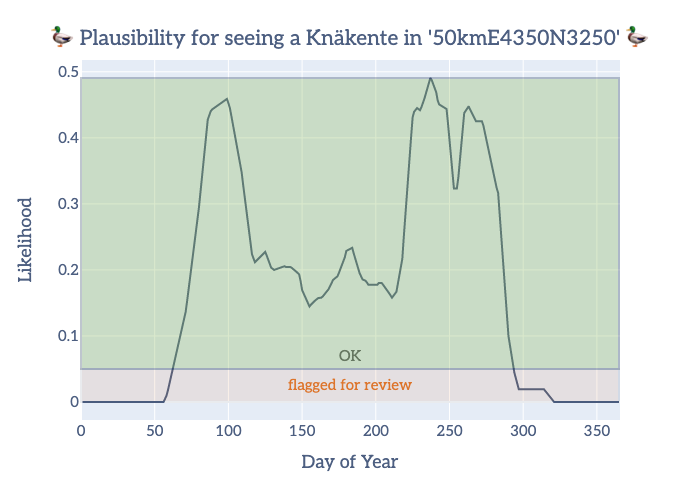

In [14]:
plot_plausibility_over_year(result_df, species='Knäkente', grid='50kmE4350N3250', sign='🦆')

## The White-tailed eagle (*Seeadler*)
In Germany, the White-tailed eagle can be predominantly observed in Northern regions close to seacoasts and larger rivers [3].

<img src="https://www.mein-schoener-garten.de/sites/default/files/styles/discover_1x1/public/seeadler-543213276-istock.jpg?h=c029297a&itok=uYWEU74l" alt="A White-tailed eagle." style="border-radius: 7px; width: 300px; height: auto;">

While the selected grid around Hannover is not a prime location for eagle sightings, eBird records a multitude of sightings in that area [3]. Therefore, we anticipate that a sighting in the chosen grid would typically be classified as plausible by the Emergent Filters. As can be seen in the chart below, this is the case.

Further, the White-tailed eagle is not a migratory bird, so sightings are plausible all year round. In line with this, within the chosen grid and using a 5% threshold, the White-tailed eagle would consistently be marked as plausible when applying the Emergent Filters.

During spring, the eagles engage in courtship rituals, nesting activities, and the exploration of suitable breeding habitats, contributing to an increased probability of sightings, which can again be confirmed by our Emergent Filters. According to @Christopher König, the increased likelihood of sightings in autumn may be attributed to young eagles leaving their nests and searching for suitable habitats.

It is noticeable that despite its rarity, the White-tailed eagle accounts for a relatively high percentage of sightings. This could be attributed to user bias, as the probability of reporting a sighting is much higher when it involves a white-tailed eagle compared to more common bird species.

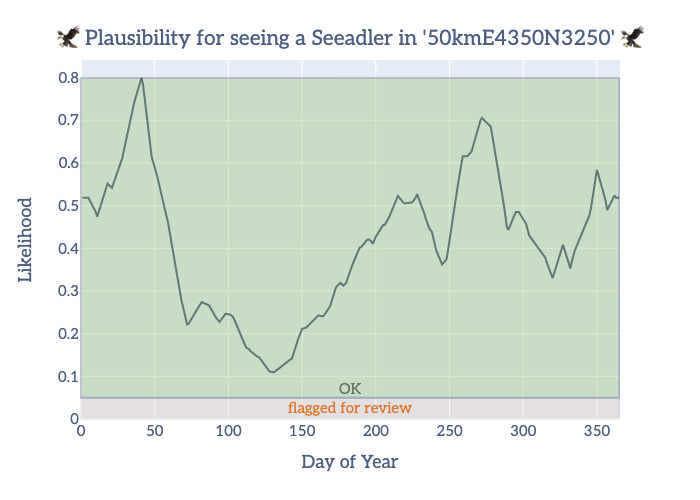

In [15]:
plot_plausibility_over_year(result_df, species='Seeadler', grid='50kmE4350N3250', sign='🦅')

## Takeaway
The visualization of two exemplary bird species indicate that for these species, the Emergent Filters align with the anticipated sighting frequencies of the respective species. For example, migratory birds are flagged as not plausible during winter time, while plausibility increases during the breeding season.

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 4️⃣ Applying Emergent Filters for flagging unusual sightings </p>

Below is an example code demonstrating how the Emergent Filters could be utilized to assess newly incoming sightings. In this process, we simply need to extract the dataframe row corresponding to the relevant species, grid, and date, and retrieve the plausibility value. If this value falls below the predetermined threshold (here set at 5%), the `flagged_for_review` flag is set to True. An expert can subsequently filter based on this flag and review the corresponding sightings. Similarly, a system with continuous values could be established, allowing the plausibility value to be directly associated with the new sighting. An expert can then sort the sightings by plausibility, starting with those having the lowest plausibility values.

In [16]:
def is_unlikely(sighting, emergent_filters_lookup, threshold=0.05):
    key = (sighting['name_species'], sighting['eea_grid_id'], sighting['day_of_year'])
    plausibility = emergent_filters_lookup.get(key, None)
    return plausibility is not None and plausibility < threshold

In [17]:
threshold = 0.05

To calculate the `flagged_for_review` column values, we first convert it to a dict as it is more efficient to compute with:

In [18]:
emergent_filters_lookup = result_df.groupby(['name_species', 'eea_grid_id', 'day_of_year'])['plausibility'].first().to_dict()

## Flag single datapoints
For demonstrating purposes, we create two datapoints of a garganey sighting; one at Jan 30 and one at Apr 1. 

In [19]:
# sighting at Apr 1 '23 (usual)
usual_knaekente = {'name_species': 'Knäkente', 'eea_grid_id': '50kmE4350N3250', 'day_of_year': 100}

# sighting at Jan 30 '23 (unusual)
unusual_knaekente = {'name_species': 'Knäkente', 'eea_grid_id': '50kmE4350N3250', 'day_of_year': 30}

To flag the datapoints individually, we can use the `is_unlikely()` function above, which retrieves the plausibility value that matches the species, grid, and date of the datapoint and returns a boolean whether it is above or below the given threshold.

In [20]:
print('Should this datapoint be flagged for review?', is_unlikely(usual_knaekente, emergent_filters_lookup, threshold))
print('Should this datapoint be flagged for review?', is_unlikely(unusual_knaekente, emergent_filters_lookup, threshold))

Should this datapoint be flagged for review? False
Should this datapoint be flagged for review? True


## Flag a whole dataframe
If we want to calculate the plausibility for all sightings in a dataframe, we simply perform a pandas apply of the same `is_unlikely()` function: 

In [21]:
# flag a whole dataframe
result_df['flagged_for_review'] = result_df.apply(is_unlikely, args=(emergent_filters_lookup, threshold,), axis=1)
result_df

,name_species,eea_grid_id,day_of_year,plausibility,flagged_for_review
0,Alpenschneehuhn,50kmE4000N2500,1,0.0,True
1,Alpenschneehuhn,50kmE4000N2500,2,0.0,True
2,Alpenschneehuhn,50kmE4000N2500,3,0.0,True
3,Alpenschneehuhn,50kmE4000N2500,4,0.0,True
4,Alpenschneehuhn,50kmE4000N2500,5,0.0,True
...,...,...,...,...,...
2207515,Zwergohreule,50kmE4650N3150,361,0.0,True
2207516,Zwergohreule,50kmE4650N3150,362,0.0,True
2207517,Zwergohreule,50kmE4650N3150,363,0.0,True
2207518,Zwergohreule,50kmE4650N3150,364,0.0,True


# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 5️⃣ Store the filters for later use </p>

In [22]:
with open(target_path, 'wb') as file:
    pickle.dump(emergent_filters_lookup, file)

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 6️⃣ Initial Assessment: Possible Opportunities and Limitations </p>
The Emergent Filters represent a method already implemented in practice and established at eBird. Their evaluation has demonstrated promising results, suggesting that Emergent Filters can effectively contribute to identifying unusual observations [1]. 
Further, our exploratory assessment for the garganey and the White-tailed eagle show that the emergent filters align with the expected sighting frequencies of the respective species.

Therefore, we intend to utilize this approach as a benchmark for our outlier analysis. While they are relatively resource-efficient to compute, they narrow down data points solely on location and time, disregarding other features that can significantly influence plausibility. For instance, a garganey with Atlas code 0 might be highly plausible, while one with a high Atlas code (indicating breeding) could be quite unusual outside of the breeding season.

We aim to benchmark the Emergent Filters against our outlier analysis to test whether the outlier analysis, which considers all features and employs common outlier detection algorithms, performs better, equal, or worse. This comparison will help us determine whether the established Emergent Filters, while straightforward, are indeed effective or if the more comprehensive outlier analysis offers superior performance by encompassing all available features and calculations.

# References
[1] Yu, Jun, et al. "Automated data verification in a large-scale citizen science project: a case study." 2012 IEEE 8th International Conference on E-Science. IEEE, 2012.

[2] https://ebird.org/species/gargan; Last visited 8th Dec 2023.

[3] https://ebird.org/species/whteag; Last visited 8th Dec 2023.